In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x, t):
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Add three dimensions
        t = t.expand(-1, 1, x.shape[2], x.shape[3])  # Expand t to match x's spatial dimensions
        x = torch.cat([x, t], dim=1)

        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.upsample(x2)
        x4 = F.relu(self.conv3(x3 + x1))
        return self.conv4(x4)

class DiffusionModel:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        self.model = SimpleUNet(in_channels=2, out_channels=1)

    def forward_diffusion(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        epsilon = torch.randn_like(x0)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon, epsilon

    def train_step(self, x0, optimizer):
        optimizer.zero_grad()
        t = torch.randint(0, self.num_timesteps, (x0.shape[0],), device=x0.device)
        x_t, epsilon = self.forward_diffusion(x0, t)
        predicted_noise = self.model(x_t, t.float() / self.num_timesteps)
        loss = F.mse_loss(epsilon, predicted_noise)
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sample(self, num_samples, image_size):
        device = next(self.model.parameters()).device
        x = torch.randn(num_samples, 1, image_size, image_size, device=device)
        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
            predicted_noise = self.model(x, t_tensor.float() / self.num_timesteps)
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            beta_t = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (
                1
                / torch.sqrt(alpha_t)
                * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
                + torch.sqrt(beta_t) * noise
            )
        return x

# The rest of the code (get_data_loader, train function, and main execution) remains the same

Using device: cpu


Epoch 1/1: 100%|██████████| 938/938 [06:15<00:00,  2.50batch/s, Loss=0.0540, Avg Loss=0.0765]


Epoch 1/1 completed.
Average Loss: 0.0765
Time Elapsed: 375.35 seconds
Estimated Time Remaining: 0.00 seconds
--------------------------------------------------
Training completed.
Total training time: 375.35 seconds
Generated samples shape: torch.Size([16, 1, 28, 28])


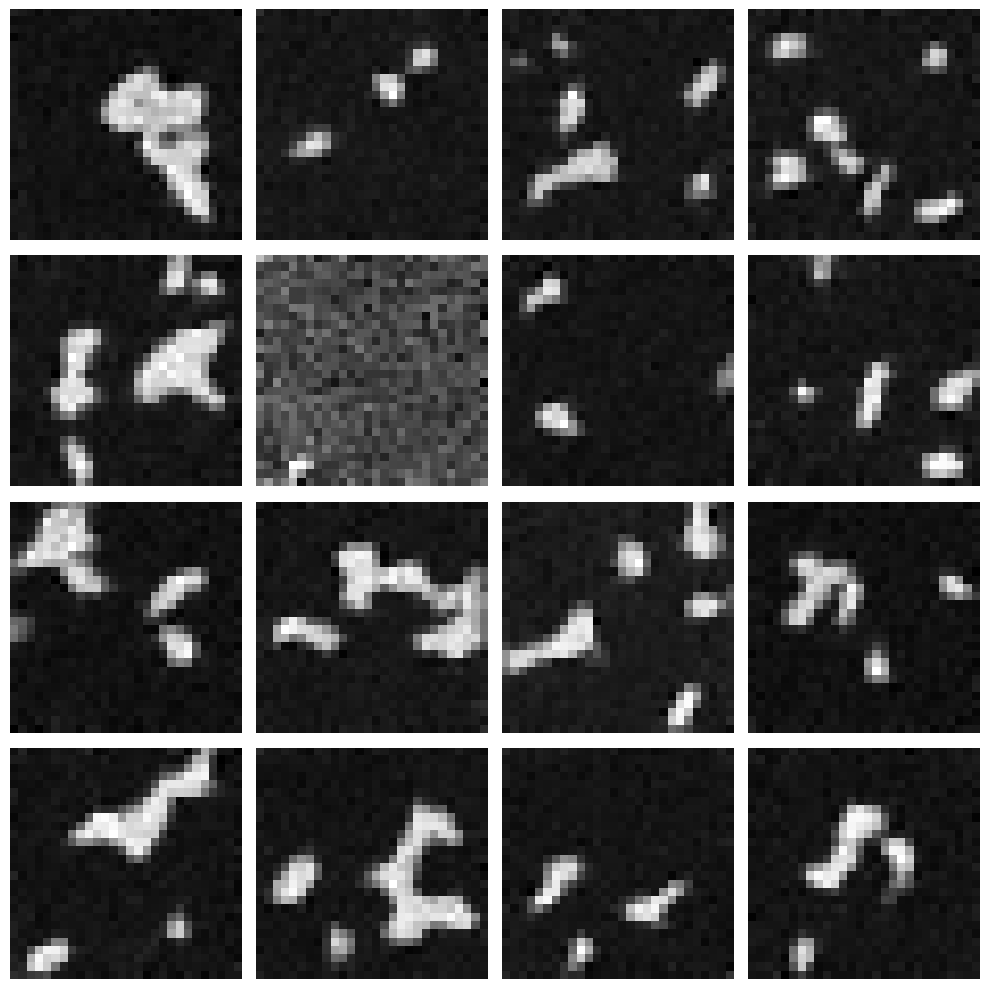

In [8]:
import time
from tqdm import tqdm

# Data loading
def get_data_loader(batch_size=64):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with improved progress indication
def train(diffusion, train_loader, num_epochs=10, device="cpu"):
    optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3)
    diffusion.model.to(device)

    total_batches = len(train_loader)
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for batch, (images, _) in enumerate(train_loader):
                images = images.to(device)
                loss = diffusion.train_step(images, optimizer)
                epoch_loss += loss

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({
                    "Loss": f"{loss:.4f}",
                    "Avg Loss": f"{epoch_loss / (batch + 1):.4f}"
                })

        avg_epoch_loss = epoch_loss / total_batches
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} completed.")
        print(f"Average Loss: {avg_epoch_loss:.4f}")
        print(f"Time Elapsed: {elapsed_time:.2f} seconds")
        print(f"Estimated Time Remaining: {elapsed_time * (num_epochs - epoch - 1) / (epoch + 1):.2f} seconds")
        print("-" * 50)

    print("Training completed.")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    diffusion = DiffusionModel()
    train_loader = get_data_loader()

    train(diffusion, train_loader, num_epochs=1, device=device)

    # Generate samples
    samples = diffusion.sample(num_samples=16, image_size=28).cpu()

    # You can save or display these samples as needed
    print("Generated samples shape:", samples.shape)

    # Optional: Add code here to visualize the generated samples
    import matplotlib.pyplot as plt
    
    samples = samples.squeeze(1)  # Remove the channel dimension
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x, t):
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Add three dimensions
        t = t.expand(-1, 1, x.shape[2], x.shape[3])  # Expand t to match x's spatial dimensions
        x = torch.cat([x, t], dim=1)

        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.upsample(x2)
        x4 = F.relu(self.conv3(x3 + x1))
        return self.conv4(x4)

class DiffusionModel:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        self.model = SimpleUNet(in_channels=2, out_channels=1)

    def forward_diffusion(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        epsilon = torch.randn_like(x0)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon, epsilon

    def train_step(self, x0, optimizer):
        optimizer.zero_grad()
        t = torch.randint(0, self.num_timesteps, (x0.shape[0],), device=x0.device)
        x_t, epsilon = self.forward_diffusion(x0, t)
        predicted_noise = self.model(x_t, t.float() / self.num_timesteps)
        loss = F.mse_loss(epsilon, predicted_noise)
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def sample(self, num_samples, image_size):
        device = next(self.model.parameters()).device
        x = torch.randn(num_samples, 1, image_size, image_size, device=device)
        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
            predicted_noise = self.model(x, t_tensor.float() / self.num_timesteps)
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            beta_t = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (
                1
                / torch.sqrt(alpha_t)
                * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise)
                + torch.sqrt(beta_t) * noise
            )
        return x

class NumpyDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file)['images']
        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.data = self.data.unsqueeze(1)  # Add a channel dimension if needed

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Data loading
def get_data_loader(npz_file, batch_size=64):
    dataset = NumpyDataset(npz_file)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with improved progress indication
def train(diffusion, train_loader, num_epochs=10, device="cpu"):
    optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=1e-3)
    diffusion.model.to(device)

    total_batches = len(train_loader)
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for batch, images in enumerate(train_loader):
                images = images.to(device)
                loss = diffusion.train_step(images, optimizer)
                epoch_loss += loss

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({
                    "Loss": f"{loss:.4f}",
                    "Avg Loss": f"{epoch_loss / (batch + 1):.4f}"
                })

        avg_epoch_loss = epoch_loss / total_batches
        elapsed_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} completed.")
        print(f"Average Loss: {avg_epoch_loss:.4f}")
        print(f"Time Elapsed: {elapsed_time:.2f} seconds")
        print(f"Estimated Time Remaining: {elapsed_time * (num_epochs - epoch - 1) / (epoch + 1):.2f} seconds")
        print("-" * 50)

    print("Training completed.")
    print(f"Total training time: {time.time() - start_time:.2f} seconds")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    diffusion = DiffusionModel()
    npz_file = '../data_fixed32.npz'  # Replace with your .npz file path
    train_loader = get_data_loader(npz_file)

    train(diffusion, train_loader, num_epochs=1, device=device)

    # Generate samples
    samples = diffusion.sample(num_samples=16, image_size=28).cpu()

    # You can save or display these samples as needed
    print("Generated samples shape:", samples.shape)

    # Optional: Add code here to visualize the generated samples
    samples = samples.squeeze(1)  # Remove the channel dimension
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 